## Just test if we can do stokes flow on a 3d cube

### 0. Import packages

In [1]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *

%matplotlib widget

### 1. Create the starting functions and meshes

### 1a. Make a unit cube mesh

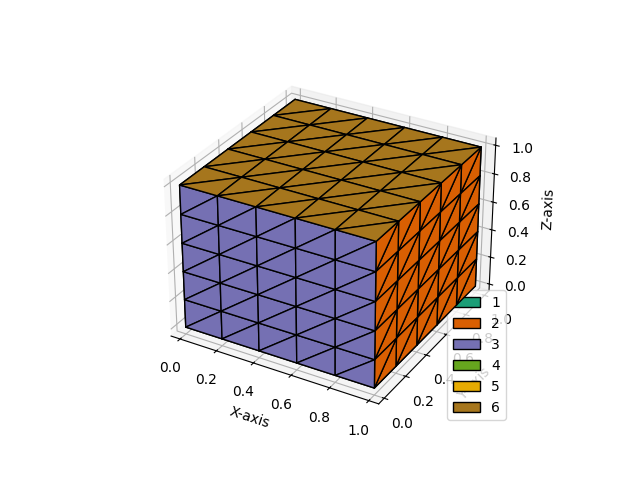

In [2]:
nx, ny, nz = 5, 5, 5

mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure().add_subplot(projection='3d')

firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()
plt.show()

### 1b. Make a rectangular prism mesh

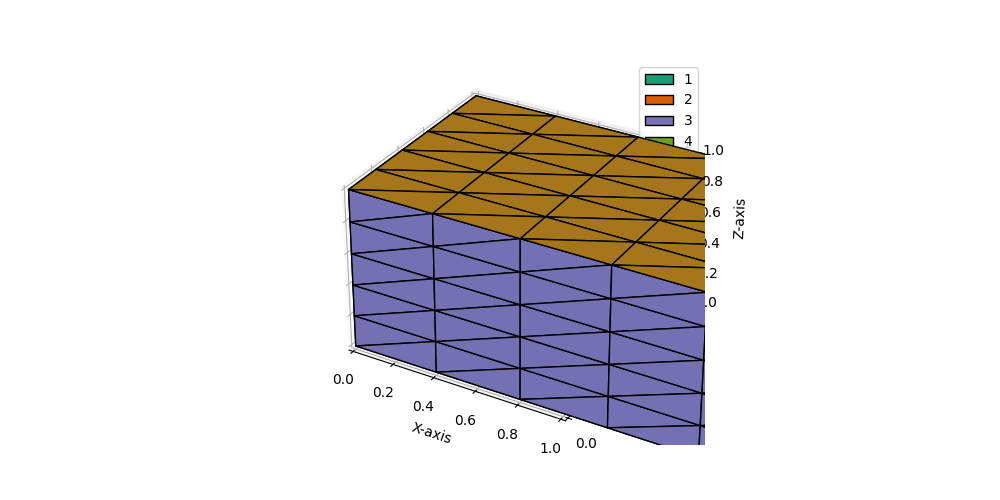

In [3]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
expr = firedrake.as_vector([Lx * x, y,z])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1c. Make a rectangular prism with a sloped surface

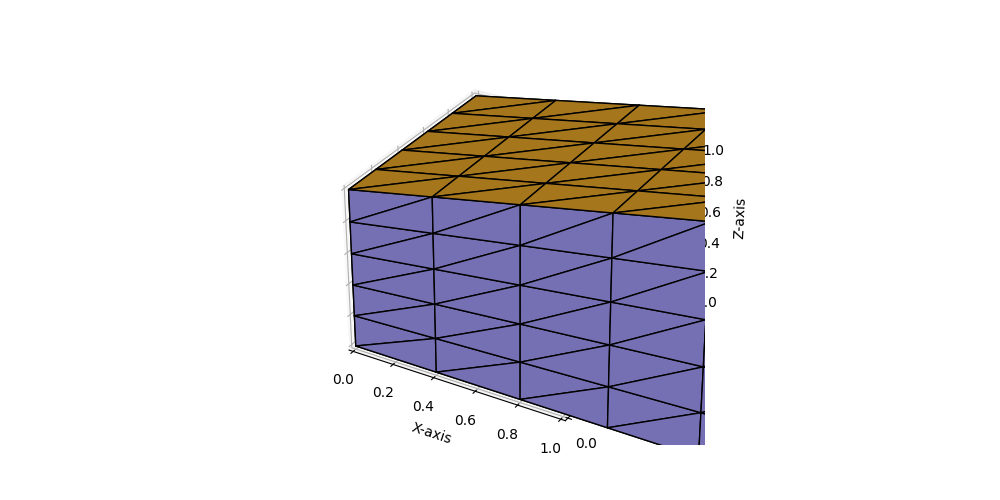

In [4]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
Lz = Constant(1.0) + (x / Lx) * 1
expr = firedrake.as_vector([Lx * x, y,z * Lz])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)

element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1d. Make a sloped bed with same angle slope (box on a slope)

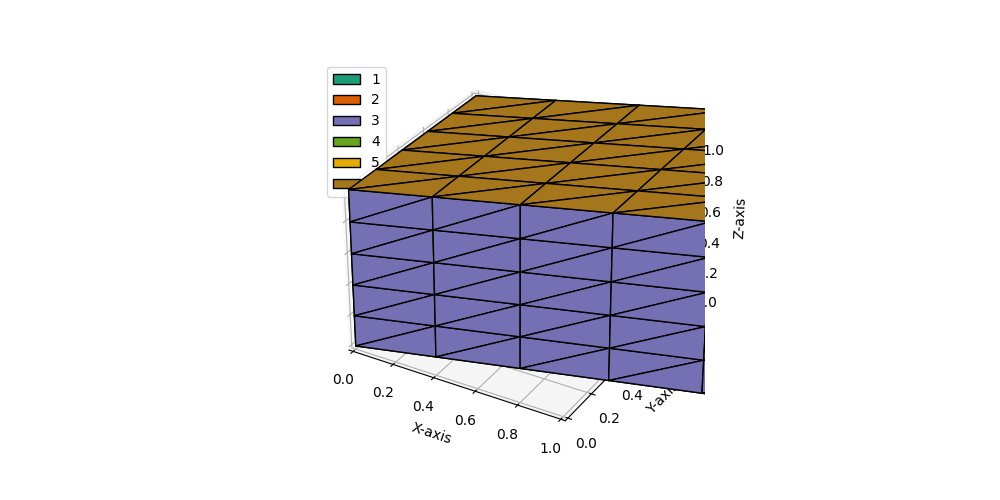

In [5]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(2.0) # How long we want the x to be
Lz = Constant(1.0) # How much extra height on the z-axis
expr = firedrake.as_vector([Lx * x, y,z + Lz * (x / Lx)])

Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1e. Now set up a thickness gradient on a slope (slope bed and slope surface)

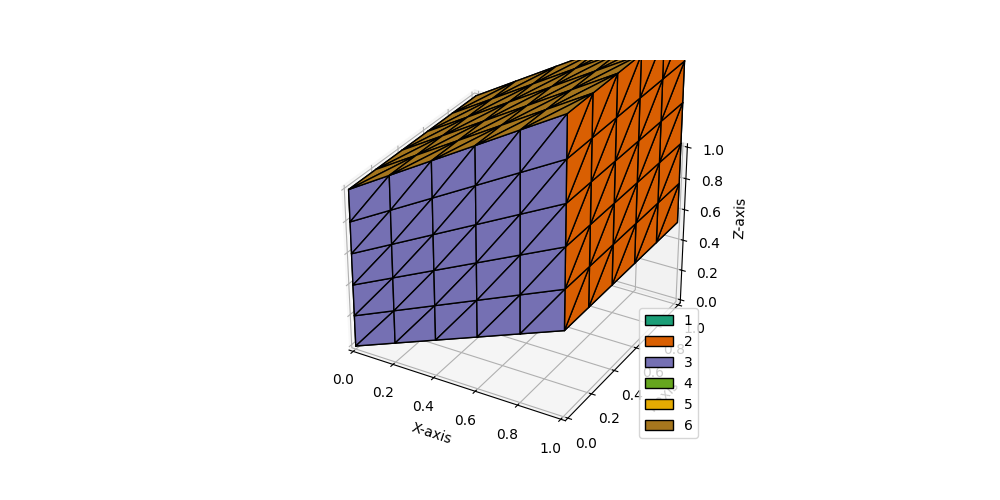

In [6]:
nx, ny, nz = 5, 5, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(1.0) # How long we want the x to be
Lz = Constant(1.0) # Initial thickness
Ly = Constant(1.0) # How wide we want the y to be
bed_start = Constant(0.0) # Where the bed starts
bed_slope = Constant(30 * np.pi / 180) # bed slope (first term given as degrees)
surf_slope = Constant(45 * np.pi / 180) # surface slope (first term given as degrees)

# Physical x and y
X = Lx * x
Y = Ly * y


# Compute bed and surface elevation
bed = bed_slope * X
surf = Lz + surf_slope * X

# Interpolate z between bed and surface
z_new = bed + z * (surf - bed)

expr = firedrake.as_vector([Lx * x, 
                            y, 
                            z_new])


Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')


ax.autoscale()
plt.legend()
plt.show()

### 1f. Scale this up to be real glacier size and thickness

Mesh Heirarchy Firedrake

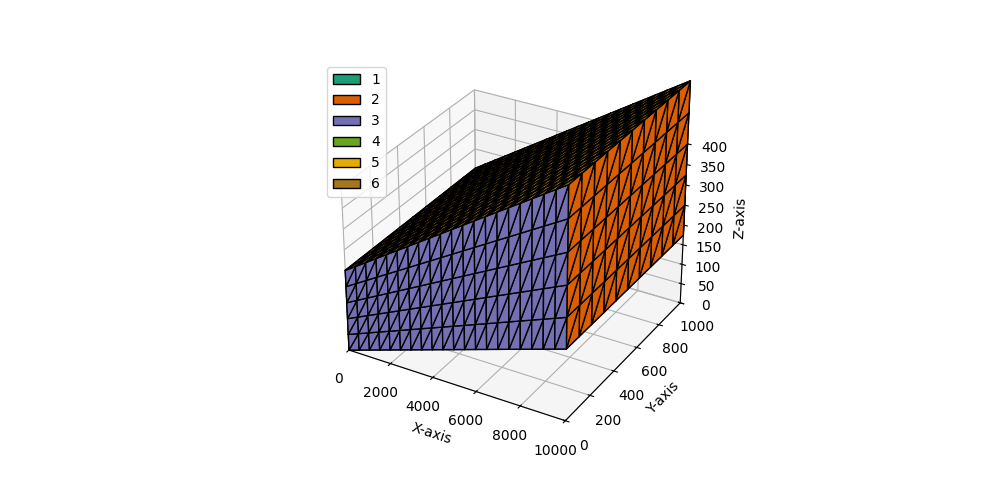

In [7]:
nx, ny, nz = 20, 10, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(10000) # How long we want the x to be
Ly = Constant(1000) # How wide we want y to be
Lz = Constant(200) # Initial thickness

bed_start = Constant(0.0) # Where the bed starts
bed_slope = Constant(1 * np.pi / 180) # bed slope (first term given as degrees)
surf_slope = Constant(2 * np.pi / 180) # surface slope (first term given as degrees)

# Physical x and y
X = Lx * x
Y = Ly * y


# Compute bed and surface elevation
bed = bed_slope * X
surf = Lz + surf_slope * X

# Interpolate z between bed and surface
z_new = bed + z * (surf - bed)

expr = firedrake.as_vector([Lx * x, 
                            Ly * y, 
                            z_new])


Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)

ax.autoscale()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

ax.set_xlim([0, 10000])
ax.set_ylim([0, 1000])
ax.set_zlim([0, 400])

plt.legend()
plt.show()

### 1g. Mesh that is based on x,y,z data

### 1g.2dtest

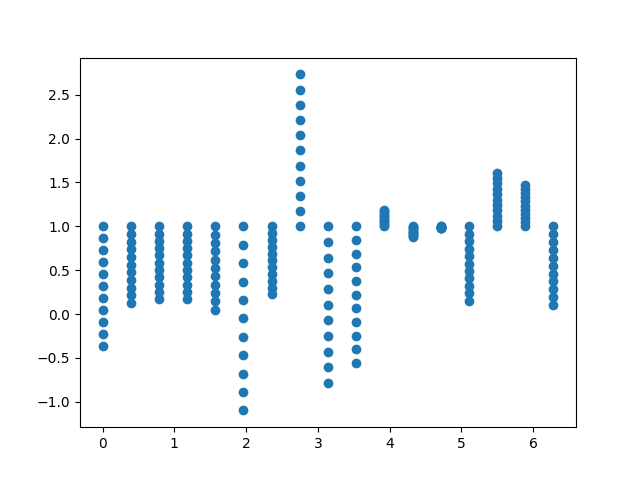

In [8]:
from firedrake import *
from firedrake.__future__ import interpolate

base_mesh = IntervalMesh(16, 0, 2*pi)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=10)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
bathymetry = np.random.randn(17)

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))
extruded_bathymetry = Function(extruded_space)
extruded_bathymetry.dat.data_wo[:] = bathymetry
# Build a new coordinate field by change of coordinates.
x, y = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, extruded_bathymetry + y * (1-extruded_bathymetry)]),
        unit_extruded_mesh.coordinates.function_space()
    )
)
# Finally build the mesh you are actually after.
mesh = Mesh(new_coordinates)


## Plot using scatter since we can't plot Tensor product using triplot
fig,ax = plt.subplots()

ax.scatter(mesh.coordinates.dat.data_ro[:,0], mesh.coordinates.dat.data_ro[:,1])

### 1g.3dtest

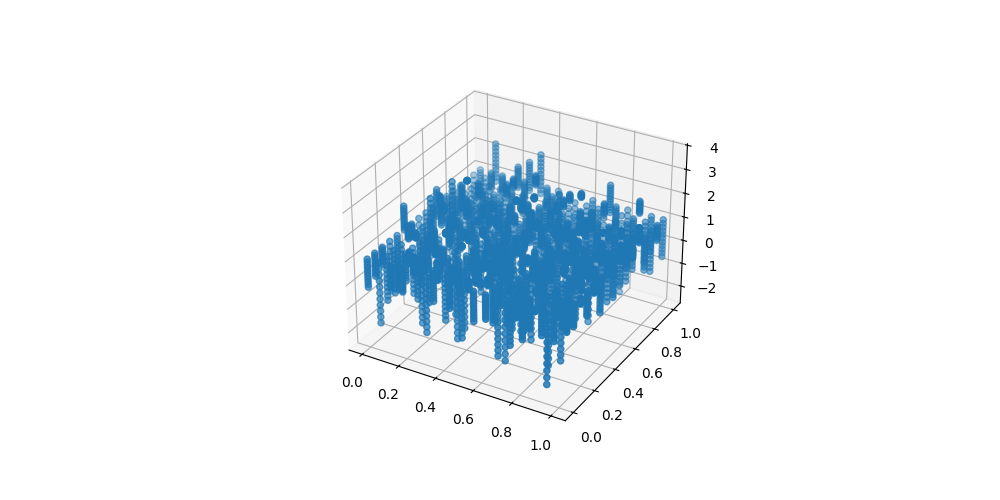

In [9]:
from firedrake import *
from firedrake.__future__ import interpolate

nx = 16
ny = 16
base_mesh = UnitSquareMesh(nx, ny)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=10)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
bathymetry = np.random.randn(nx+1,ny+1) # num cells + 1

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))
extruded_bathymetry = Function(extruded_space)
extruded_bathymetry.dat.data_wo[:] = bathymetry.flatten()
# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, extruded_bathymetry + z * (1-extruded_bathymetry)]),
        unit_extruded_mesh.coordinates.function_space()
    )
)
# Finally build the mesh you are actually after.
mesh = Mesh(new_coordinates)


## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh.coordinates.dat.data_ro[:,0], mesh.coordinates.dat.data_ro[:,1], mesh.coordinates.dat.data_ro[:,2])

### 1g.3dtest.with2surface

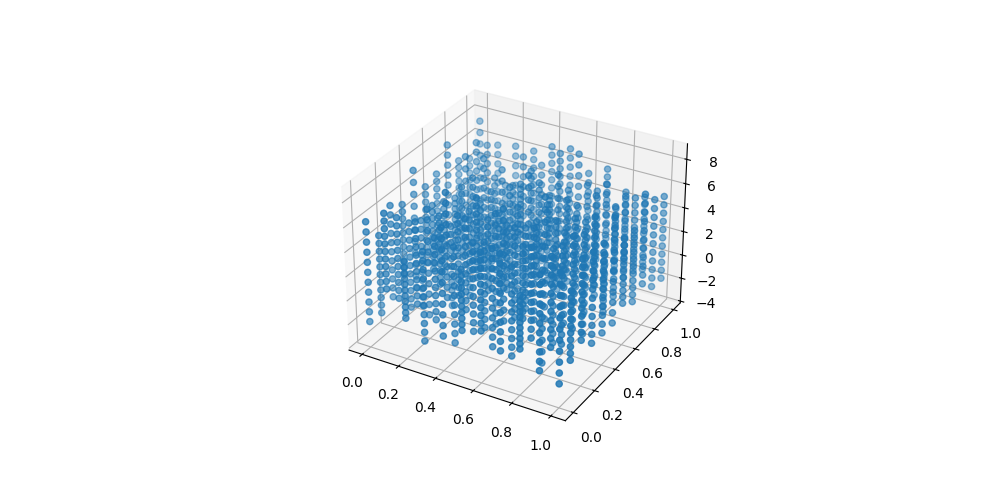

In [10]:
from firedrake import *
from firedrake.__future__ import interpolate

nx = 10
ny = 10
base_mesh = UnitSquareMesh(nx, ny)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=10)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
## Bed and surface DEM resolution should be nx+1, ny+1 as to match the coordinates of the mesh.
bed = np.random.randn(nx+1,ny+1)*1e0 - 1 # num cells + 1
surface = np.random.randn(nx+1,ny+1)*1e0 + 5 # num cells + 1

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))

## Extrude the bed and surface
extruded_bed = Function(extruded_space)
extruded_bed.dat.data_wo[:] = bed.flatten()

extruded_surface = Function(extruded_space)
extruded_surface.dat.data_wo[:] = surface.flatten()

# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, extruded_bed + z * (1-extruded_bed) + z * extruded_surface]),
        unit_extruded_mesh.coordinates.function_space()
    )
)


# Finally build the mesh you are actually after.
mesh = Mesh(new_coordinates)


## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh.coordinates.dat.data_ro[:,0], mesh.coordinates.dat.data_ro[:,1], mesh.coordinates.dat.data_ro[:,2])

### 1g.3dtest.with2surface using rectangular mesh

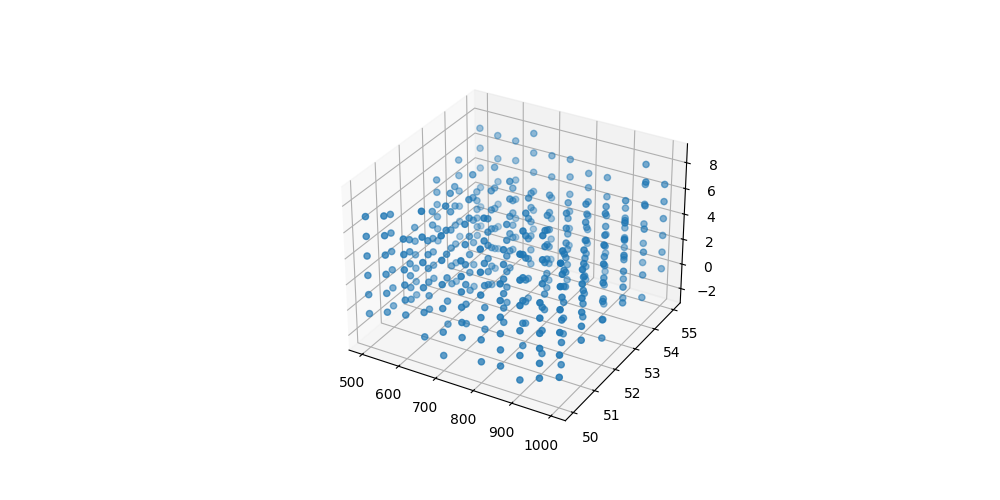

In [11]:
from firedrake import *
from firedrake.__future__ import interpolate

nx = 10
ny = 5

Lx = 1000.0 # x extent, get this from the DEM
Ly = 55.0 # y extent, get this from the DEM

origin_x = 500. # origin (lower left corner) in x, get this from the DEM
origin_y = 50. # origin (lower left corner) in y, get this from the DEM

base_mesh = RectangleMesh(nx,ny, Lx, Ly, originX=origin_x, originY=origin_y)
# Make a height 1 mesh.
unit_extruded_mesh = ExtrudedMesh(base_mesh, layers=5)

base_fs = FunctionSpace(base_mesh, "CG", 1)

x,y, = SpatialCoordinate(base_mesh)

# You could set this field any way you like.
## Bed and surface DEM resolution should be nx+1, ny+1 as to match the coordinates of the mesh.
bed = np.random.randn(nx+1,ny+1)*1e0 - 1 # num cells + 1
surface = np.random.randn(nx+1,ny+1)*1e0 + 5 # num cells + 1

# Now we transfer the bathymetry field into a depth-averaged field.
extruded_element = FiniteElement("R", "interval", 0)
extruded_space = FunctionSpace(unit_extruded_mesh,
                                TensorProductElement(base_fs.ufl_element(),
                                                    extruded_element))

## Extrude the bed and surface
extruded_bed = Function(extruded_space)
extruded_bed.dat.data_wo[:] = bed.flatten()

extruded_surface = Function(extruded_space)
extruded_surface.dat.data_wo[:] = surface.flatten()

# Build a new coordinate field by change of coordinates.
x, y, z = SpatialCoordinate(unit_extruded_mesh)
new_coordinates = assemble(
    interpolate(
        as_vector([x, y, extruded_bed + z * (1-extruded_bed) + z * extruded_surface]),
        unit_extruded_mesh.coordinates.function_space()
    )
)


# Finally build the mesh you are actually after.
mesh = Mesh(new_coordinates)


## Plot using scatter since we can't plot Tensor product using triplot
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')

ax.scatter(mesh.coordinates.dat.data_ro[:,0], mesh.coordinates.dat.data_ro[:,1], mesh.coordinates.dat.data_ro[:,2])

### 2. Set up the function spaces

In [12]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 3)
Y = velocity_space * pressure_space
y = firedrake.Function(Y)
u, p = firedrake.split(y)
v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx



### 3. boundary conditions on the faces

In [ ]:
face_ids = list(range(1, 7))

bc_stokes = []
for id in face_ids:
    if id == 6: pass # Skip the top face (id 5) for now
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundary
        bc_stokes.append(bc)

In [17]:
## If this is an extruded mesh then do this instead

face_ids = ['top', 'bottom', 1, 2, 3, 4]

bc_stokes = []
for id in face_ids:
    if id == 'top': pass # Skip the top face (id 5) for now
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundary
        bc_stokes.append(bc)

### 4. Solve the stokes problem

In [18]:


basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

### 5. Plot the results

In [19]:
x_coords = mesh.coordinates.dat.data[:,0]
y_coords = mesh.coordinates.dat.data[:,1]
z_coords = mesh.coordinates.dat.data[:,2]

u_solve = np.zeros(len(x_coords))
v_solve = np.zeros(len(y_coords))
w_solve = np.zeros(len(z_coords))

for n, i in enumerate(y.at(mesh.coordinates.dat.data[:])):
    u_solve[n] = i[0][0] * spy
    v_solve[n] = i[0][1] * spy
    w_solve[n] = i[0][2] * spy

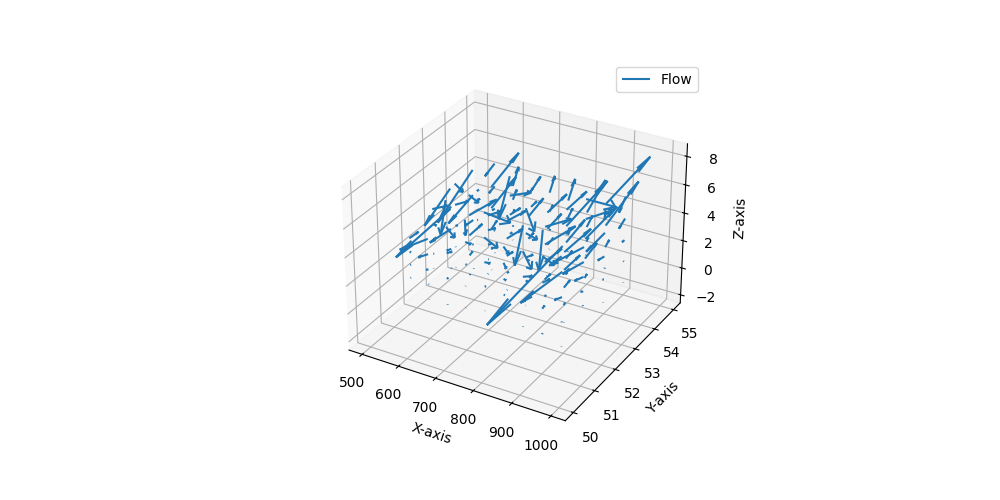

In [20]:
ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')
ax.autoscale()
ax.quiver(x_coords, y_coords, z_coords, u_solve, v_solve, w_solve, length=1e5, label='Flow') # Adjus, normalize=False, arrow_length_ratio=0.4,)

# Set the axis labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

ax.legend()

### 5a. Plot with colors for flow strength

In [21]:
def plot_3d_quiver(x, y, z, u, v, w, length=0.1):
    c = np.sqrt(np.abs(v) ** 2 + np.abs(u) ** 2 + np.abs(w) ** 2)
    c = (c.ravel() - c.min()) / np.ptp(c)
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 1)))
    # Colormap
    c = plt.cm.jet(c)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    im = ax.quiver(x, y, z, u, v, w, colors=c, length=length)

    plt.show()

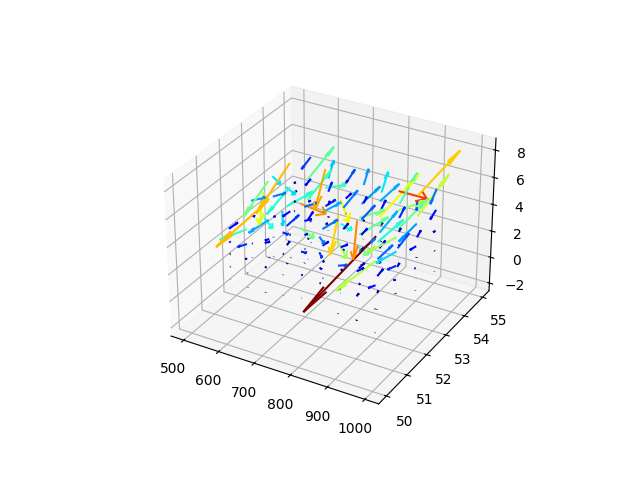

In [22]:
plot_3d_quiver(x_coords, y_coords, z_coords, u_solve, v_solve, w_solve, length=1e5)

### 5. Save the results

In [26]:
output_file = firedrake.output.VTKFile("flowfield_cube.pvd")
output_file.write(y.sub(0))